In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('../../data/processed/WESAD/data_processed/60s/eda_data.csv', index_col=0)
data.head()

,ACC_x_mean,ACC_y_mean,ACC_z_mean,net_acc_mean,net_acc_std,EDA_mean,EDA_std,EDA_slope,RESP_rate,RESP_regularity,HR,IBI,RMSSD,SDNN,pNN50,lf/hf,label,subject,focus_label
0,39.440333,-46.955667,8.793000,62.509319,0.882039,0.543319,0.023242,-0.000332,21.553199,1.570205,65.169736,934.570312,175.003100,111.375230,80.952381,11.630831,1,8,1
1,38.923333,-47.723000,2.584333,62.509540,0.880962,0.506580,0.019543,-0.000188,23.055443,1.519763,72.240500,867.980072,176.003230,161.166671,60.294118,12.649603,1,8,1
2,47.692667,-29.041000,22.627000,62.718167,1.718567,0.456703,0.016456,-0.000233,21.277109,1.480561,71.581982,867.300725,151.608449,139.516646,58.823529,2.126393,1,8,1
3,49.833667,-22.594000,-0.084333,62.904860,1.599754,0.384330,0.006068,-0.000072,20.043427,1.482505,79.216759,803.082192,190.237895,171.587550,54.166667,6.147040,1,8,1
4,46.174000,-31.084000,11.585333,62.834104,3.193127,0.352556,0.008620,-0.000122,20.511318,1.409333,77.463893,809.289384,205.663228,156.013496,59.722222,2.089990,1,8,1


In [3]:
subjects = data['subject'].unique()

In [4]:
def safe_slope(x):
    if len(x) < 2 or np.all(np.isnan(x)):
        return np.nan
    try:
        return np.polyfit(range(len(x)), x, 1)[0]
    except np.linalg.LinAlgError:
        return np.nan

def add_features_mean_based(df):
    df['hr_diff'] = df['HR'].diff()
    df['hr_center'] = df['HR'] - df['HR'].mean()
    df['hr_slope'] = df['HR'].rolling(window=3, min_periods=2).apply(safe_slope, raw=True)
    df['hr_zscore'] = (df['HR'] - df['HR'].mean()) / df['HR'].std()

    df['lf_hf_log'] = np.log1p(df['lf/hf'])

    df['resp_zscore'] = (df['RESP_rate'] - df['RESP_rate'].mean()) / df['RESP_rate'].std()

    df['EDA_slope_clipped'] = df['EDA_slope'].clip(-0.002, 0.005)
    df['EDA_mean_clip'] = df['EDA_mean'].clip(upper=df['EDA_mean'].quantile(0.99))
    df['EDA_slope_log'] = np.sign(df['EDA_slope_clipped']) * np.log1p(np.abs(df['EDA_slope_clipped']))
    df['EDA_slope_pos'] = (df['EDA_slope'] > 0).astype(int)

    df['eda_hr_interaction'] = df['EDA_mean'] * df['HR']
    df['eda_resp_ratio'] = df['EDA_std'] / df['RESP_regularity']
    df['hr_resp_interaction'] = df['HR'] * df['RESP_rate']
    df['hr_resp_z_interaction'] = df['hr_zscore'] * df['resp_zscore']
    df['hrv_composite'] = (df['RMSSD'] + df['SDNN'] + df['pNN50']) / 3
    df['hrv_stress_index'] = df['SDNN'] / df['RMSSD']

    df['arousal_index'] = df['HR'] * df['EDA_mean'] * df['RESP_rate']

    return df

In [5]:
data_feature_addon = []

In [6]:
for s in subjects:
    df = data[data['subject'] == s].copy().reset_index(drop=True)
    df = add_features_mean_based(df)
    df.dropna(inplace=True)
    data_feature_addon.append(df)

In [7]:
df = pd.concat(data_feature_addon, ignore_index=True)

In [8]:
df.head()

,ACC_x_mean,ACC_y_mean,ACC_z_mean,net_acc_mean,net_acc_std,EDA_mean,EDA_std,EDA_slope,RESP_rate,RESP_regularity,...,EDA_mean_clip,EDA_slope_log,EDA_slope_pos,eda_hr_interaction,eda_resp_ratio,hr_resp_interaction,hr_resp_z_interaction,hrv_composite,hrv_stress_index,arousal_index
0,38.923333,-47.723000,2.584333,62.509540,0.880962,0.506580,0.019543,-0.000188,23.055443,1.519763,...,0.506580,-0.000188,0,36.595576,0.012859,1665.536722,-0.536824,132.488006,0.915703,843.727204
1,47.692667,-29.041000,22.627000,62.718167,1.718567,0.456703,0.016456,-0.000233,21.277109,1.480561,...,0.456703,-0.000233,0,32.691726,0.011114,1523.057639,0.010330,116.649542,0.920243,695.585412
2,49.833667,-22.594000,-0.084333,62.904860,1.599754,0.384330,0.006068,-0.000072,20.043427,1.482505,...,0.384330,-0.000072,0,30.445355,0.004093,1587.775363,0.037372,138.664037,0.901963,610.229268
3,46.174000,-31.084000,11.585333,62.834104,3.193127,0.352556,0.008620,-0.000122,20.511318,1.409333,...,0.352556,-0.000122,0,27.310387,0.006116,1588.886525,0.079135,140.466315,0.758587,560.172034
4,53.685333,-4.781667,-9.681333,63.136894,3.537549,0.325207,0.010485,-0.000140,22.006812,1.499234,...,0.325207,-0.000140,0,24.864265,0.006993,1682.568644,-0.097406,142.989983,0.863585,547.183192


In [9]:
#df.to_csv('../../data/processed/WESAD/data_processed/180s/addon_feature_data.csv')

In [10]:
df.columns.unique

<bound method Index.unique of Index(['ACC_x_mean', 'ACC_y_mean', 'ACC_z_mean', 'net_acc_mean', 'net_acc_std',
       'EDA_mean', 'EDA_std', 'EDA_slope', 'RESP_rate', 'RESP_regularity',
       'HR', 'IBI', 'RMSSD', 'SDNN', 'pNN50', 'lf/hf', 'label', 'subject',
       'focus_label', 'hr_diff', 'hr_center', 'hr_slope', 'hr_zscore',
       'lf_hf_log', 'resp_zscore', 'EDA_slope_clipped', 'EDA_mean_clip',
       'EDA_slope_log', 'EDA_slope_pos', 'eda_hr_interaction',
       'eda_resp_ratio', 'hr_resp_interaction', 'hr_resp_z_interaction',
       'hrv_composite', 'hrv_stress_index', 'arousal_index'],
      dtype='object')>

In [11]:
features = ['EDA_mean', 'EDA_std', 'EDA_slope', 'RESP_rate', 'HR', 'RMSSD', 'SDNN',
       'hr_diff', 'hr_center', 'hr_slope',
       'EDA_slope_clipped', 'hr_resp_interaction', 'hr_resp_z_interaction',
       'hrv_stress_index']

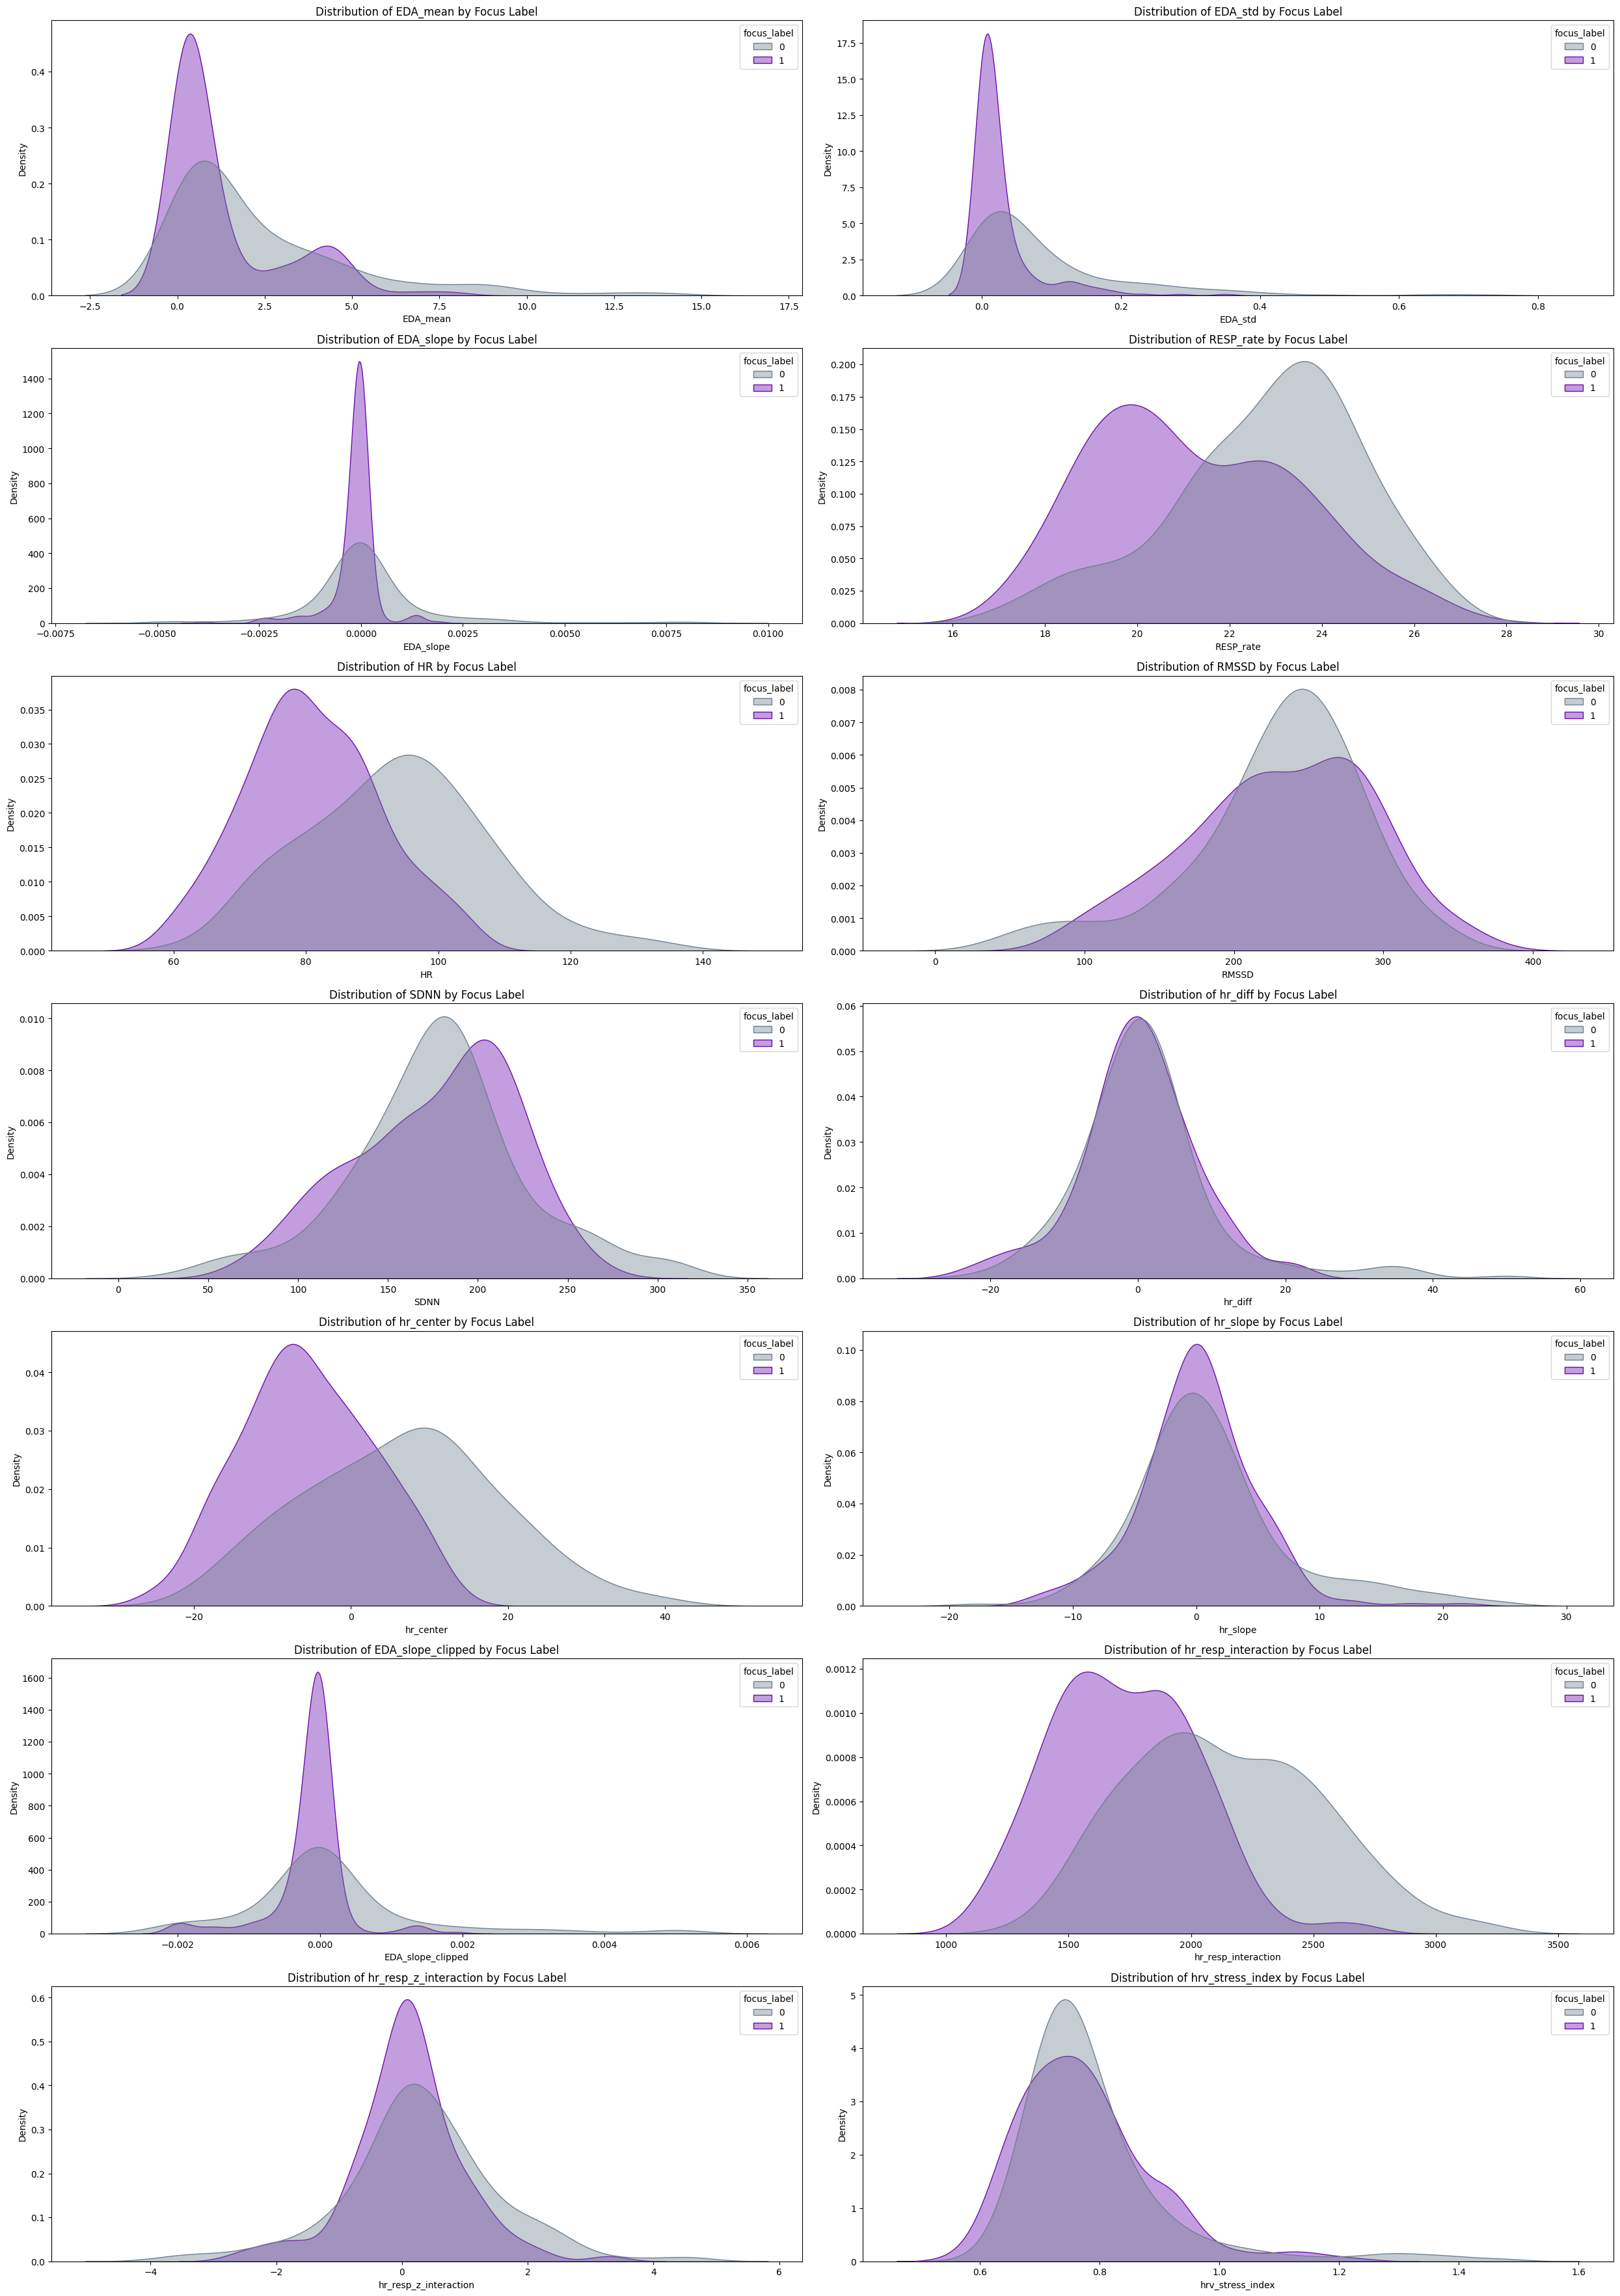

In [12]:
plt.figure(figsize=(25, 40))
for i, feature in enumerate(features, 1):
    plt.subplot(8, 2, i)
    sns.kdeplot(data=df, x=feature, hue='focus_label', common_norm=False,
                palette={0: "#708090", 1: "#6A0DAD"}, fill=True, alpha=0.4)
    plt.title(f'Distribution of {feature} by Focus Label')
plt.tight_layout()
plt.show()

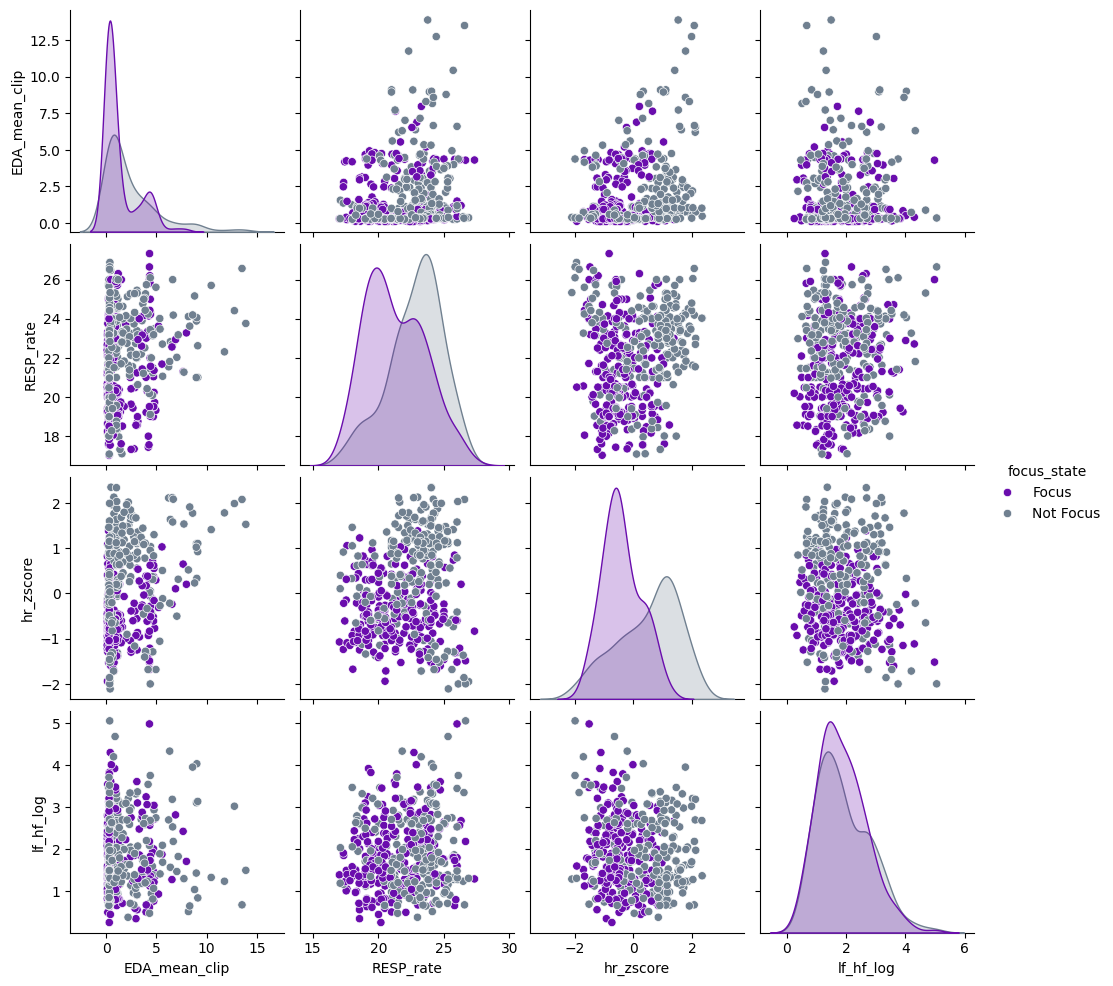

In [13]:
selected_features = ['EDA_mean_clip', 'RESP_rate', 'hr_zscore', 'lf_hf_log']
df["focus_state"] = df["focus_label"].map({0: "Not Focus", 1: "Focus"})
sns.pairplot(df[selected_features + ["focus_state"]], hue="focus_state", diag_kind="kde", 
             palette={"Not Focus": "#708090", "Focus": "#6A0DAD"})
plt.show()

# Feature selection using this flow
1. plot heatmap correlation

2. cut-off feature that have correlate > 0.9 left just one feature

3. Random forest training and using SHAP to understand feature importance

4. Top-N feature selection
### By using this flow we will got top-N feature ;)

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
feature_acc = [feature for feature in df.columns if 'acc' in feature.lower()]

In [16]:
df = df.drop(columns=feature_acc + ['focus_state'])
df.head()

,EDA_mean,EDA_std,EDA_slope,RESP_rate,RESP_regularity,HR,IBI,RMSSD,SDNN,pNN50,...,EDA_mean_clip,EDA_slope_log,EDA_slope_pos,eda_hr_interaction,eda_resp_ratio,hr_resp_interaction,hr_resp_z_interaction,hrv_composite,hrv_stress_index,arousal_index
0,0.506580,0.019543,-0.000188,23.055443,1.519763,72.240500,867.980072,176.003230,161.166671,60.294118,...,0.506580,-0.000188,0,36.595576,0.012859,1665.536722,-0.536824,132.488006,0.915703,843.727204
1,0.456703,0.016456,-0.000233,21.277109,1.480561,71.581982,867.300725,151.608449,139.516646,58.823529,...,0.456703,-0.000233,0,32.691726,0.011114,1523.057639,0.010330,116.649542,0.920243,695.585412
2,0.384330,0.006068,-0.000072,20.043427,1.482505,79.216759,803.082192,190.237895,171.587550,54.166667,...,0.384330,-0.000072,0,30.445355,0.004093,1587.775363,0.037372,138.664037,0.901963,610.229268
3,0.352556,0.008620,-0.000122,20.511318,1.409333,77.463893,809.289384,205.663228,156.013496,59.722222,...,0.352556,-0.000122,0,27.310387,0.006116,1588.886525,0.079135,140.466315,0.758587,560.172034
4,0.325207,0.010485,-0.000140,22.006812,1.499234,76.456720,826.605903,196.175470,169.414197,63.380282,...,0.325207,-0.000140,0,24.864265,0.006993,1682.568644,-0.097406,142.989983,0.863585,547.183192


In [17]:
numeric_feature = df.select_dtypes(include=[np.number]).drop(columns=['focus_label', 'label', 'subject'])
corr = numeric_feature.corr()

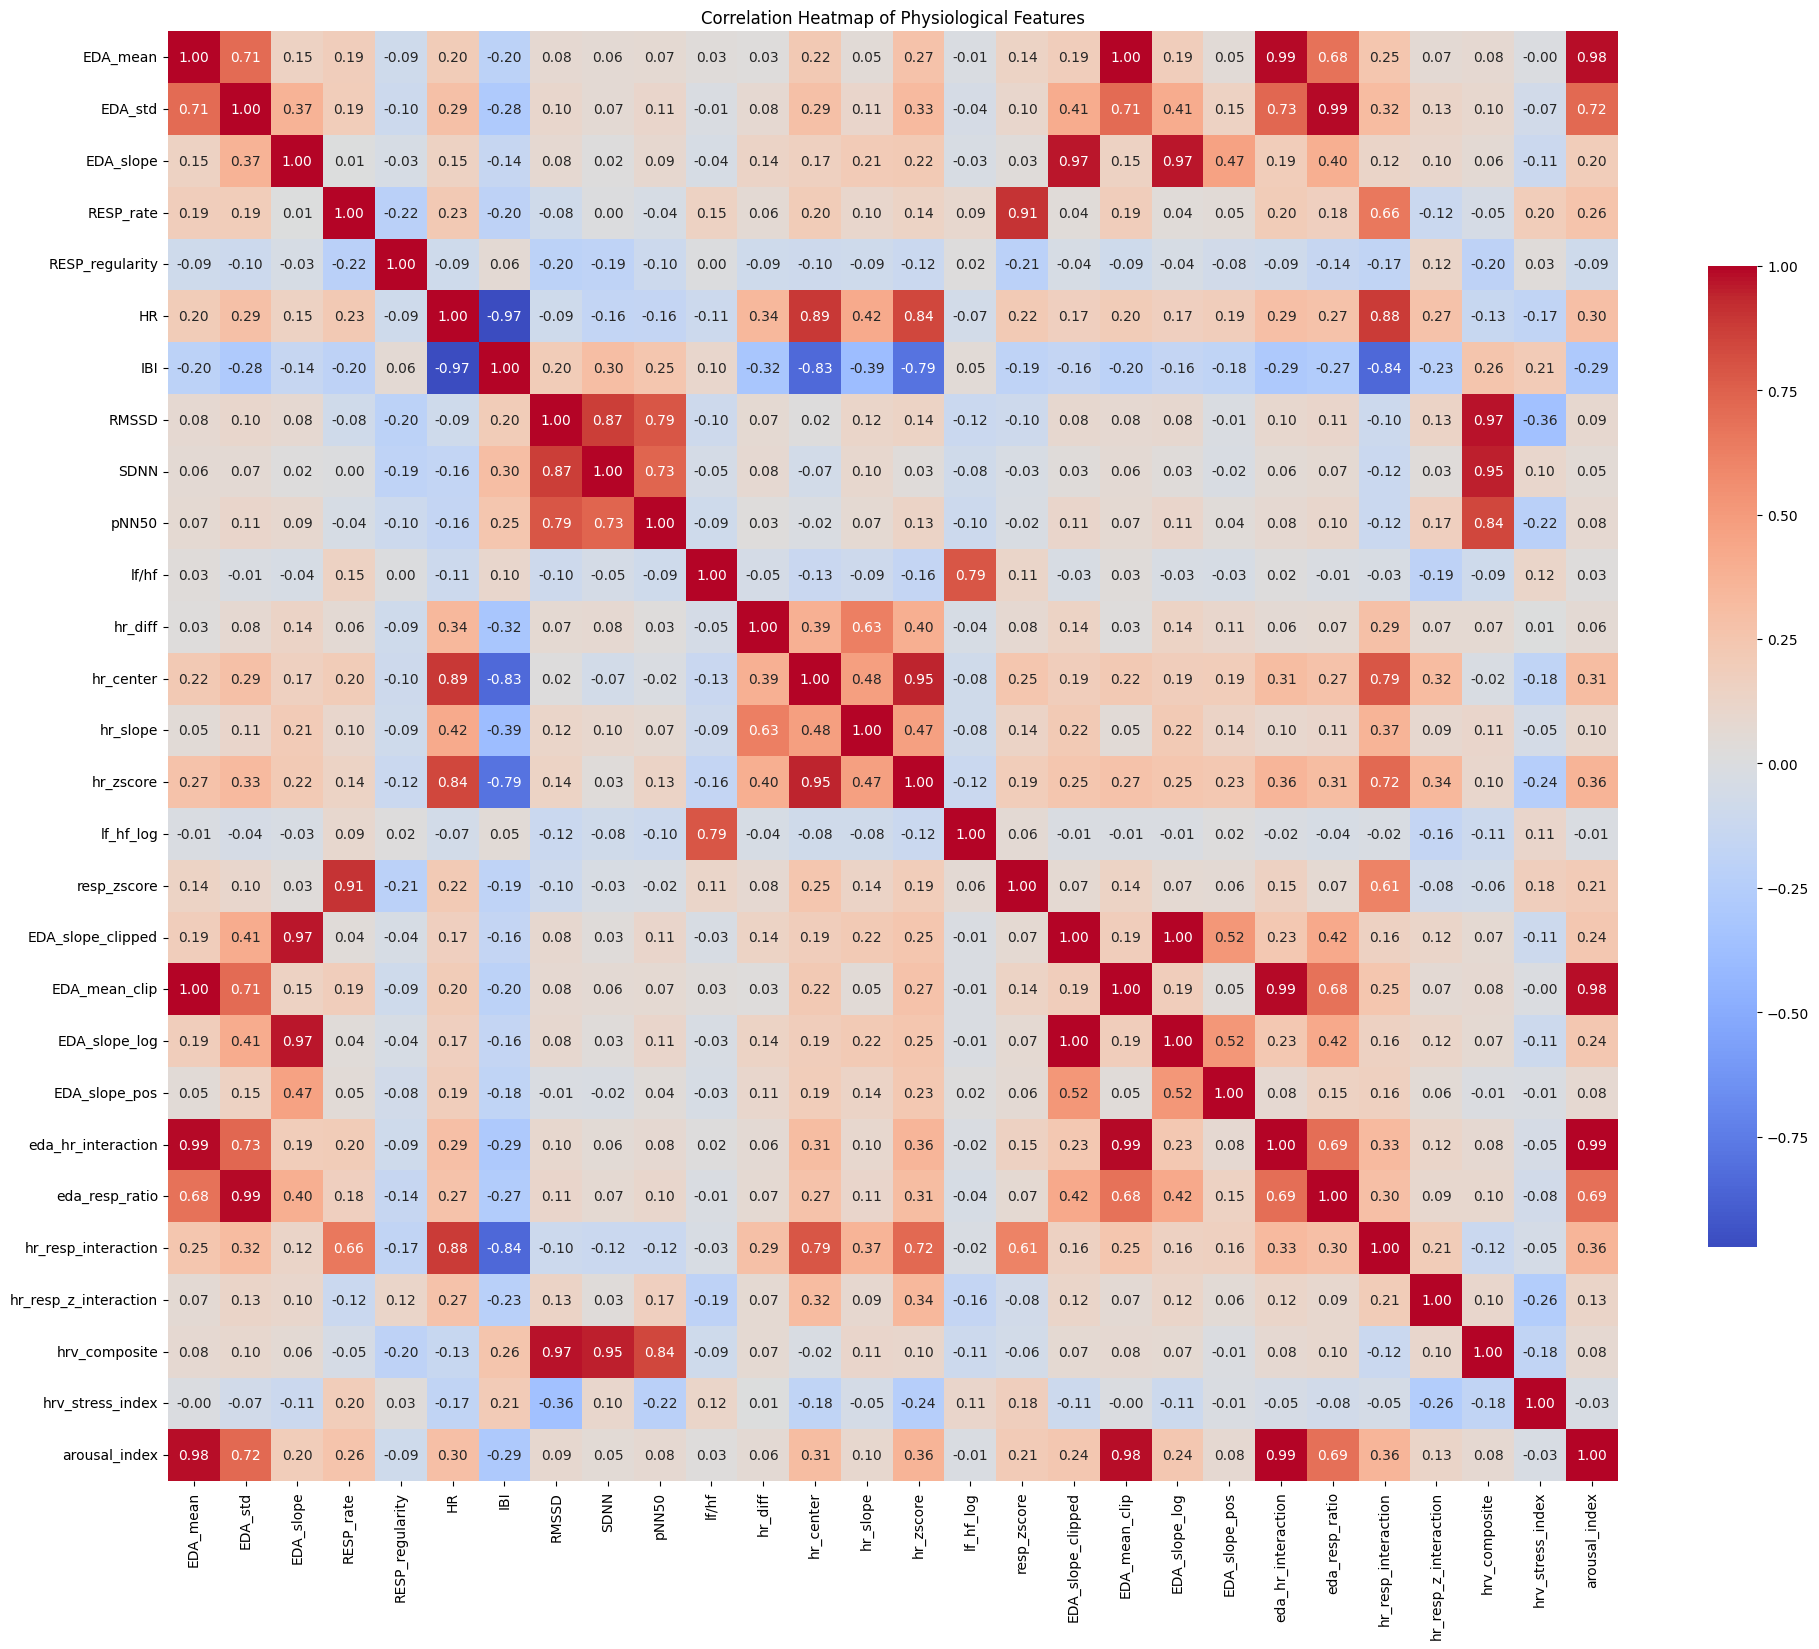

In [18]:
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={'shrink': 0.5})
plt.title("Correlation Heatmap of Physiological Features")
plt.tight_layout()
plt.show()

In [19]:
df.columns

Index(['EDA_mean', 'EDA_std', 'EDA_slope', 'RESP_rate', 'RESP_regularity',
       'HR', 'IBI', 'RMSSD', 'SDNN', 'pNN50', 'lf/hf', 'label', 'subject',
       'focus_label', 'hr_diff', 'hr_center', 'hr_slope', 'hr_zscore',
       'lf_hf_log', 'resp_zscore', 'EDA_slope_clipped', 'EDA_mean_clip',
       'EDA_slope_log', 'EDA_slope_pos', 'eda_hr_interaction',
       'eda_resp_ratio', 'hr_resp_interaction', 'hr_resp_z_interaction',
       'hrv_composite', 'hrv_stress_index', 'arousal_index'],
      dtype='object')

In [20]:
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

In [21]:
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

In [22]:
df = df.drop(columns = to_drop)
df.head()

,EDA_mean,EDA_std,EDA_slope,RESP_rate,RESP_regularity,HR,RMSSD,SDNN,pNN50,lf/hf,...,subject,focus_label,hr_diff,hr_center,hr_slope,lf_hf_log,EDA_slope_pos,hr_resp_interaction,hr_resp_z_interaction,hrv_stress_index
0,0.506580,0.019543,-0.000188,23.055443,1.519763,72.240500,176.003230,161.166671,60.294118,12.649603,...,8,1,7.070764,-7.718706,7.070764,2.613710,0,1665.536722,-0.536824,0.915703
1,0.456703,0.016456,-0.000233,21.277109,1.480561,71.581982,151.608449,139.516646,58.823529,2.126393,...,8,1,-0.658518,-8.377224,3.206123,1.139880,0,1523.057639,0.010330,0.920243
2,0.384330,0.006068,-0.000072,20.043427,1.482505,79.216759,190.237895,171.587550,54.166667,6.147040,...,8,1,7.634777,-0.742447,3.488130,1.966698,0,1587.775363,0.037372,0.901963
3,0.352556,0.008620,-0.000122,20.511318,1.409333,77.463893,205.663228,156.013496,59.722222,2.089990,...,8,1,-1.752866,-2.495314,2.940955,1.128168,0,1588.886525,0.079135,0.758587
4,0.325207,0.010485,-0.000140,22.006812,1.499234,76.456720,196.175470,169.414197,63.380282,2.512798,...,8,1,-1.007172,-3.502486,-1.380019,1.256413,0,1682.568644,-0.097406,0.863585


In [23]:
numeric_feature = df.select_dtypes(include=[np.number]).drop(columns=['label', 'subject'])
corr = numeric_feature.corr()

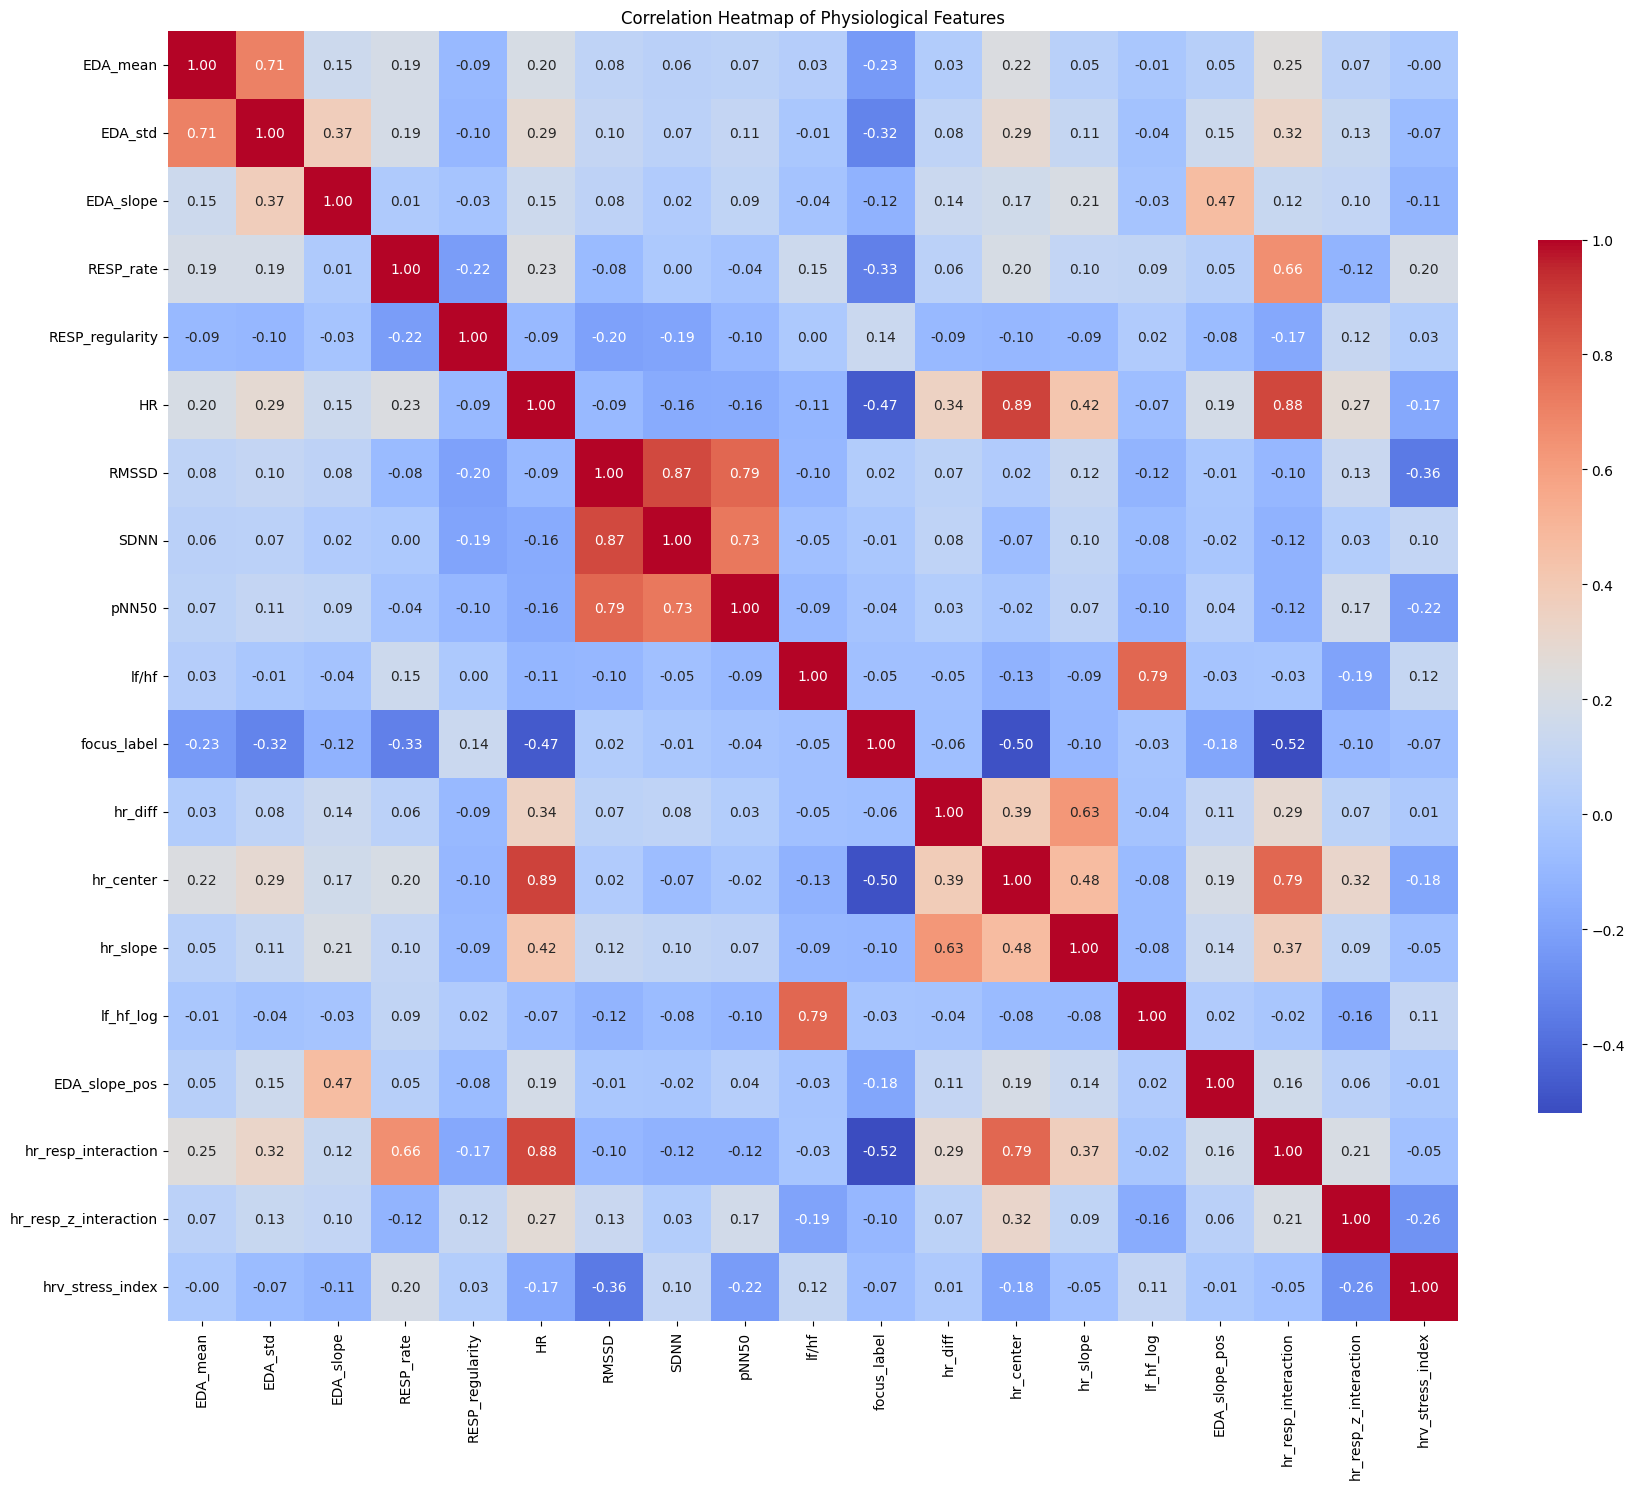

In [24]:
plt.figure(figsize=(18, 18))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={'shrink': 0.5})
plt.title("Correlation Heatmap of Physiological Features")
plt.tight_layout()
plt.show()

In [25]:
df.columns

Index(['EDA_mean', 'EDA_std', 'EDA_slope', 'RESP_rate', 'RESP_regularity',
       'HR', 'RMSSD', 'SDNN', 'pNN50', 'lf/hf', 'label', 'subject',
       'focus_label', 'hr_diff', 'hr_center', 'hr_slope', 'lf_hf_log',
       'EDA_slope_pos', 'hr_resp_interaction', 'hr_resp_z_interaction',
       'hrv_stress_index'],
      dtype='object')

In [26]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

In [27]:
X = df.drop(columns=['label', 'focus_label', 'subject'])
y = df['focus_label']

In [28]:
rfe_model = RFE(estimator=RandomForestClassifier(), n_features_to_select=15)
rfe_model.fit(X, y)
selected_features = X.columns[rfe_model.support_]

In [29]:
selected_features

Index(['EDA_mean', 'EDA_std', 'EDA_slope', 'RESP_rate', 'RESP_regularity',
       'HR', 'RMSSD', 'SDNN', 'pNN50', 'hr_diff', 'hr_center', 'hr_slope',
       'hr_resp_interaction', 'hr_resp_z_interaction', 'hrv_stress_index'],
      dtype='object')